### Prof. Pedram Jahangiry

## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)

# Module 4: ARIMA Models with StatsForecast

This notebook mirrors the original PyCaret-based ARIMA walkthrough using [StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/index.html), Nixtla's high-performance statistical forecasting library. The workflow follows the same storyline—ARIMA model identification, estimation, and forecasting—while taking advantage of StatsForecast's efficient APIs, long-format data handling, and utility support for large-scale forecasting.

In [1]:
# !pip install statsforecast
# check statsforecast version

import statsforecast
print(statsforecast.__version__)  # should be 1.5.0 or higher

/opt/anaconda3/envs/nixtla/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/opt/anaconda3/envs/nixtla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.0.2


## Resources Consulted
- [StatsForecast Documentation](https://nixtlaverse.nixtla.io/statsforecast/index.html)
- [Model References: ARIMA/AutoARIMA](https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#arima)
- [utilsforecast Evaluation Utilities](https://nixtlaverse.nixtla.io/utilsforecast)

> **Tip:** StatsForecast expects data in long format with columns `unique_id`, `ds`, `y`. We will keep the original pandas index for convenience, but derive the long-format frame for modelling steps.

## Notebook Roadmap
1. Imports, helpers, and dataset preparation.
2. Exploratory data analysis (plots, seasonal decomposition, ACF/PACF).
3. ARIMA family models in StatsForecast (AR, MA, ARIMA, SARIMA).
4. AutoARIMA for automatic model selection.
5. Baselines (`Naive`, `RandomWalkWithDrift`) and metric comparison on a 12-month holdout.
6. Model diagnostics and residual analysis.
7. Final model training, 24-step forecast, and conformal prediction intervals.
8. Model persistence with `StatsForecast.save`.

Note: for installing nixtla, use python 3.11 and pip install statsforecast. Do not use conda

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from functools import partial

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsforecast import StatsForecast
from statsforecast.models import (
    ARIMA,
    AutoARIMA,
    AutoRegressive,
    Naive,
    RandomWalkWithDrift,
)
from statsforecast.utils import AirPassengersDF

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mape, rmse, mase, rmsse

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
import inspect
import statsforecast.models as sf_models

available = [
    name for name, obj in vars(sf_models).items()
    if inspect.isclass(obj) and not name.startswith('_')
]
(sorted(available))

['ADIDA',
 'ARCH',
 'ARIMA',
 'AutoARIMA',
 'AutoCES',
 'AutoETS',
 'AutoMFLES',
 'AutoRegressive',
 'AutoTBATS',
 'AutoTheta',
 'ConformalIntervals',
 'ConstantModel',
 'CrostonClassic',
 'CrostonOptimized',
 'CrostonSBA',
 'DynamicOptimizedTheta',
 'DynamicTheta',
 'GARCH',
 'HistoricAverage',
 'Holt',
 'HoltWinters',
 'IMAPA',
 'MFLES',
 'MSTL',
 'NaNModel',
 'Naive',
 'OptimizedTheta',
 'RandomWalkWithDrift',
 'SeasonalExponentialSmoothing',
 'SeasonalExponentialSmoothingOptimized',
 'SeasonalNaive',
 'SeasonalWindowAverage',
 'SimpleExponentialSmoothing',
 'SimpleExponentialSmoothingOptimized',
 'SklearnModel',
 'TBATS',
 'TSB',
 'Theta',
 'WindowAverage',
 'ZeroModel']

In [6]:
# Local paths & constants
DATA_URL = "https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv"
HOLDOUT_HORIZON = 12
SEASON_LENGTH = 12
UNIQUE_ID = "AirPassengers"

In [7]:
# Load dataset from repository to keep parity with original notebook
raw_df = pd.read_csv(DATA_URL, index_col='Month')
raw_df.index = pd.to_datetime(raw_df.index)
raw_df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


The original PyCaret notebook relied on pandas PeriodIndex for downstream compatibility. StatsForecast operates on long-format data, so we retain both representations:
- `df_wide`: pandas Series/DataFrame with a `DatetimeIndex` for classical plotting.
- `df_long`: long-format DataFrame (`unique_id`, `ds`, `y`) required by StatsForecast.

In [8]:
df_wide = raw_df.copy()
df_wide.index = df_wide.index.to_period('M').to_timestamp('M')

# Build the long-format frame required by StatsForecast

df_long = (
    df_wide
    .assign(unique_id=UNIQUE_ID)
    .rename(columns={'Passengers': 'y'})
    .reset_index()
    .rename(columns={'Month': 'ds'})
    [["unique_id", "ds", "y"]]
)

df_long.head()

,unique_id,ds,y
0,AirPassengers,1949-01-31,112
1,AirPassengers,1949-02-28,118
2,AirPassengers,1949-03-31,132
3,AirPassengers,1949-04-30,129
4,AirPassengers,1949-05-31,121


In [9]:
# Train / holdout split (12 months for evaluation to mirror PyCaret fh=12)
train_long = df_long.iloc[:-HOLDOUT_HORIZON].copy()
test_long = df_long.iloc[-HOLDOUT_HORIZON:].copy()

train_wide = df_wide.iloc[:-HOLDOUT_HORIZON].copy()
test_wide = df_wide.iloc[-HOLDOUT_HORIZON:].copy()

train_start, train_end = train_wide.index[[0, -1]]
test_start, test_end = test_wide.index[[0, -1]]

train_start, train_end, test_start, test_end

(Timestamp('1949-01-31 00:00:00'),
 Timestamp('1959-12-31 00:00:00'),
 Timestamp('1960-01-31 00:00:00'),
 Timestamp('1960-12-31 00:00:00'))

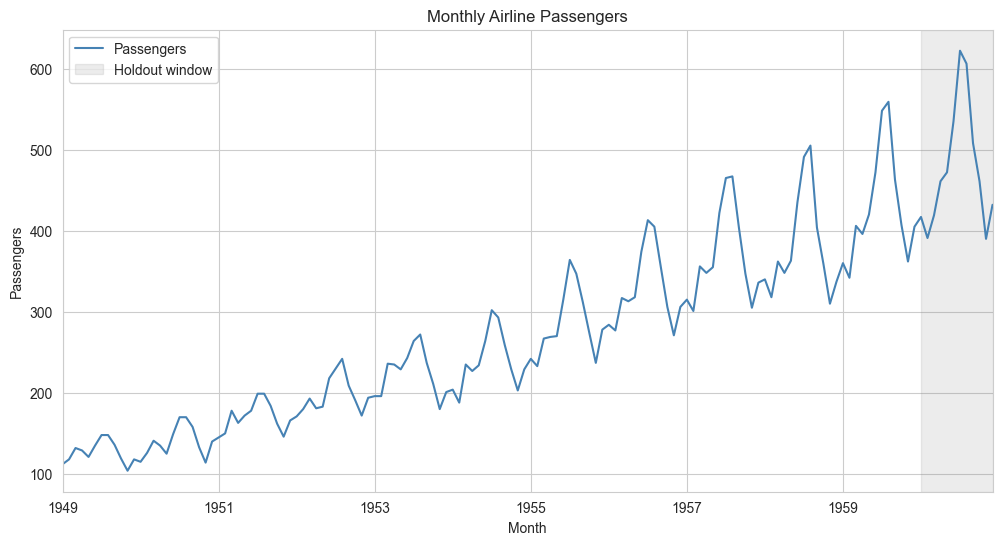

In [10]:
ax = df_wide['Passengers'].plot(color='steelblue', label='Passengers')
ax.axvspan(test_start, test_end, color='grey', alpha=0.15, label='Holdout window')
ax.set(title='Monthly Airline Passengers', xlabel='Month', ylabel='Passengers')
ax.legend()
plt.show()

## Initial Diagnostics
We replicate the PyCaret exploratory plots (ACF/PACF and seasonal decomposition) using `statsmodels`.

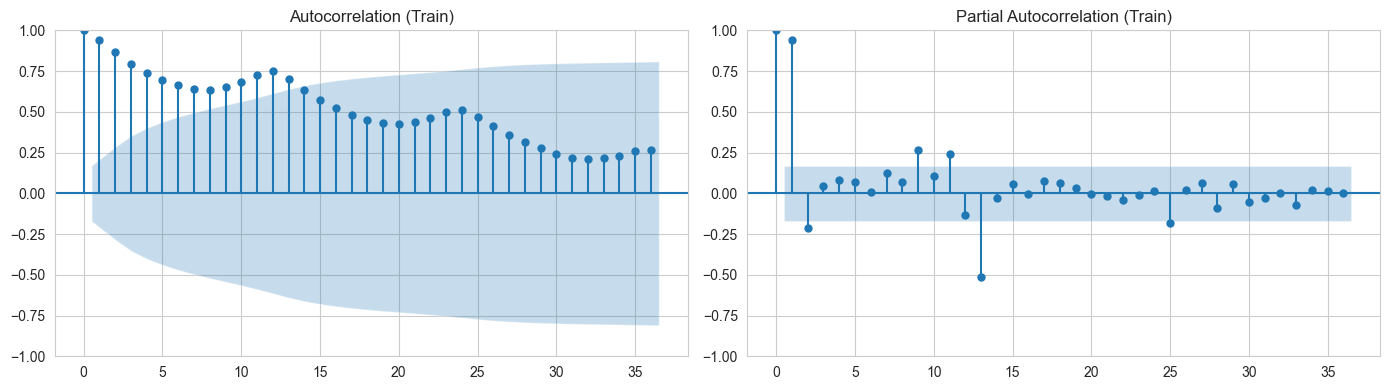

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(train_wide['Passengers'], lags=36, ax=axes[0])
plot_pacf(train_wide['Passengers'], lags=36, ax=axes[1], method='ywm')
axes[0].set_title('Autocorrelation (Train)')
axes[1].set_title('Partial Autocorrelation (Train)')
plt.tight_layout()
plt.show()

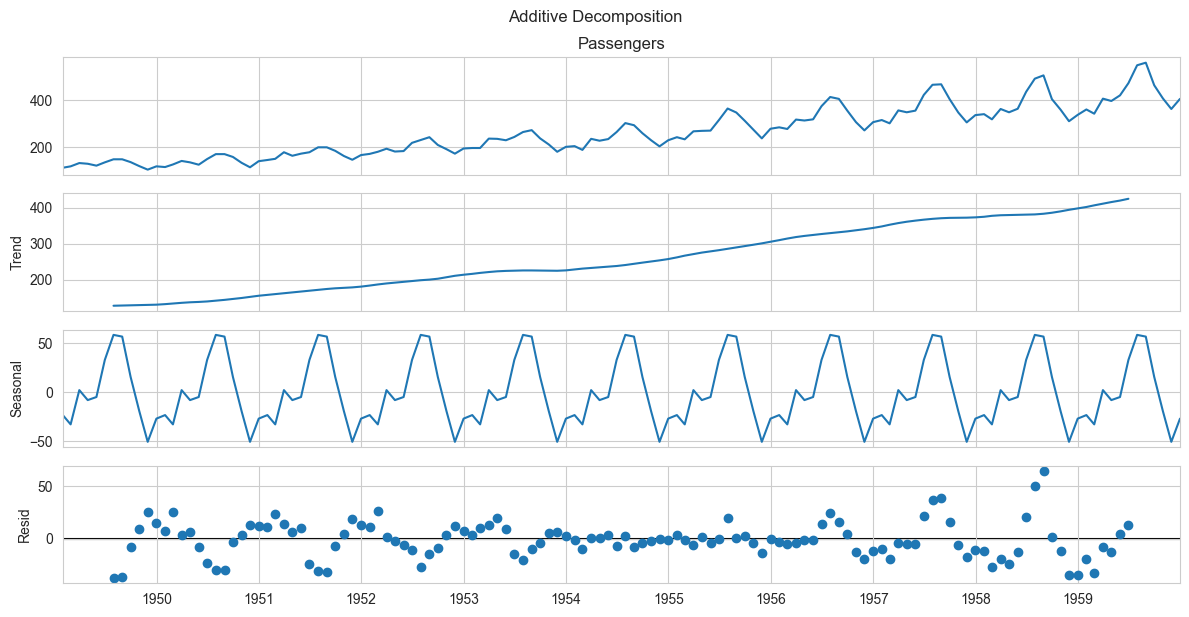

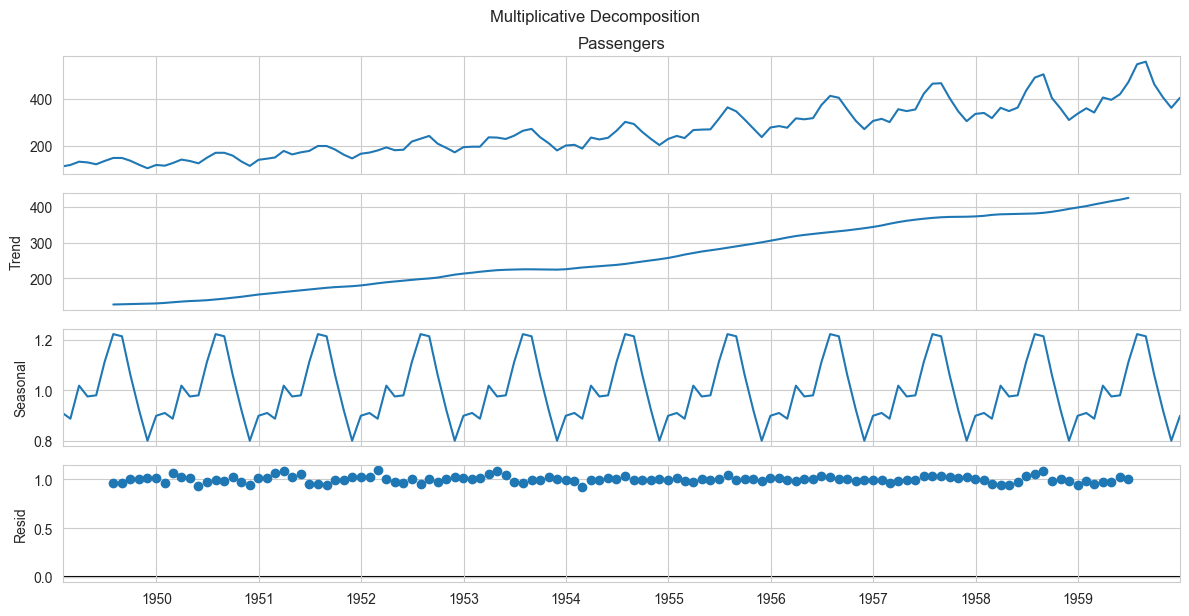

In [12]:
additive_decomp = seasonal_decompose(train_wide['Passengers'], model='additive', period=SEASON_LENGTH)
multiplicative_decomp = seasonal_decompose(train_wide['Passengers'], model='multiplicative', period=SEASON_LENGTH)

fig = additive_decomp.plot()
fig.suptitle('Additive Decomposition', y=1.02)
plt.show()

fig = multiplicative_decomp.plot()
fig.suptitle('Multiplicative Decomposition', y=1.02)
plt.show()

## Differencing Plots for Model Identification
To identify appropriate p and q parameters, we examine the differenced data. This helps us understand the stationarity properties and guide our ARIMA model selection.

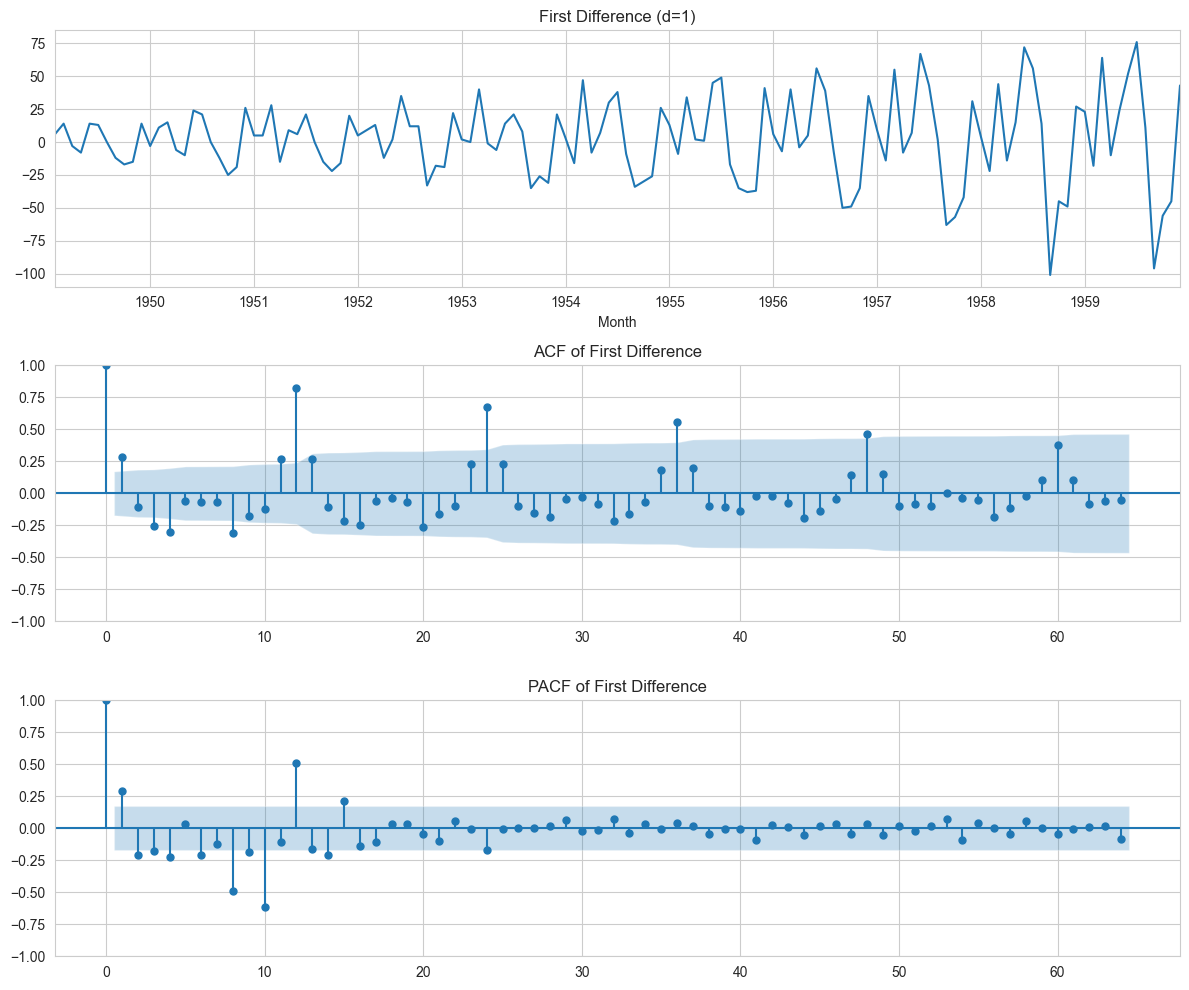

In [13]:
# First difference (d=1)
diff_1 = train_wide['Passengers'].diff().dropna()

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
diff_1.plot(ax=axes[0], title='First Difference (d=1)')
plot_acf(diff_1, lags=64, ax=axes[1])
plot_pacf(diff_1, lags=64, ax=axes[2], method='ywm')
axes[1].set_title('ACF of First Difference')
axes[2].set_title('PACF of First Difference')
plt.tight_layout()
plt.show()

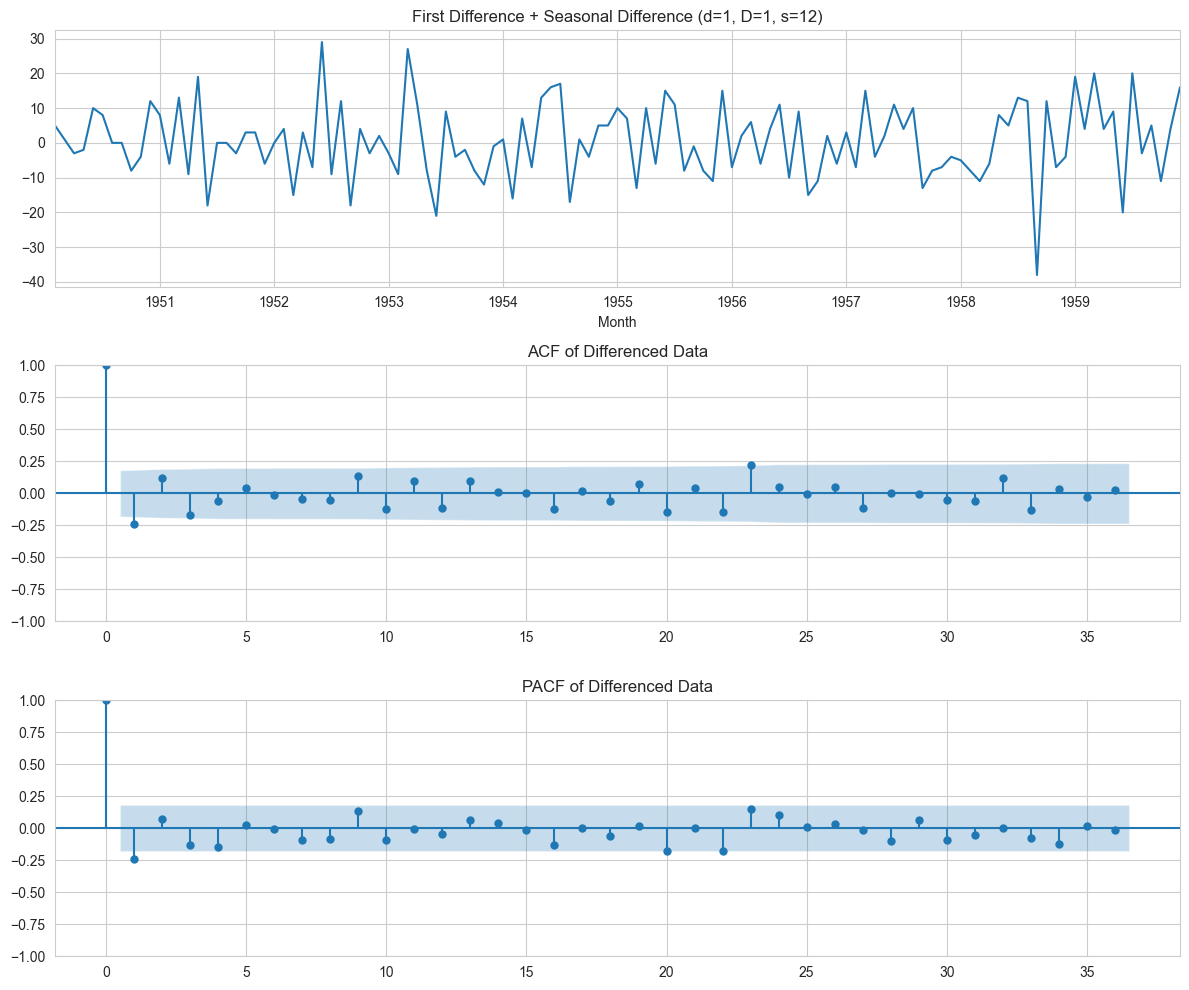

In [14]:
# First difference + Seasonal difference (d=1, D=1 at lag 12)
diff_1_12 = train_wide['Passengers'].diff().diff(12).dropna()

fig, axes = plt.subplots(3, 1, figsize=(12, 10))
diff_1_12.plot(ax=axes[0], title='First Difference + Seasonal Difference (d=1, D=1, s=12)')
plot_acf(diff_1_12, lags=36, ax=axes[1])
plot_pacf(diff_1_12, lags=36, ax=axes[2], method='ywm')
axes[1].set_title('ACF of Differenced Data')
axes[2].set_title('PACF of Differenced Data')
plt.tight_layout()
plt.show()

## Helper Utilities
StatsForecast returns forecasts in long format. We define small helpers to:
- Combine forecasts with actual holdout observations.
- Evaluate models with `utilsforecast.evaluation.evaluate`.
- Plot forecasts + residual diagnostics to mirror PyCaret's `plot_model` outputs.

In [15]:
from typing import Iterable

def evaluate_holdout(forecasts: pd.DataFrame, models: Iterable[str]) -> pd.DataFrame:
    '''Merge model forecasts with holdout observations and compute core metrics.'''
    merged = forecasts.merge(test_long, on=['unique_id', 'ds'], how='left')
    metrics = evaluate(
        df=merged,
        models=list(models),
        metrics=[
            mae,
            mape,
            rmse,
            partial(mase, seasonality=SEASON_LENGTH),
            partial(rmsse, seasonality=SEASON_LENGTH),
        ],
        train_df=train_long,
        id_col='unique_id',
        time_col='ds',
        target_col='y',
    )
    return metrics

def plot_forecast(df_actual: pd.DataFrame, forecasts: pd.DataFrame, models: Iterable[str], title: str = 'Forecast vs Actual'):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_actual['ds'], df_actual['y'], label='Actual', color='black')
    for model in models:
        ax.plot(forecasts['ds'], forecasts[model], label=model)
    ax.set(title=title, xlabel='Month', ylabel='Passengers')
    ax.legend()
    plt.show()

def plot_residuals(fitted_values: pd.DataFrame, model: str, start_date=None):
    fv = fitted_values.dropna(subset=[model]).copy()
    if start_date is not None:
        fv = fv[fv['ds'] >= start_date]
    residuals = fv['y'] - fv[model]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(residuals, kde=True, ax=axes[0], color='firebrick')
    axes[0].set_title(f'{model} Residual Distribution')
    plot_acf(residuals, lags=24, ax=axes[1])
    axes[1].set_title(f'{model} Residual ACF')
    plt.tight_layout()
    plt.show()

    return residuals

## ARIMA Models
We mirror the PyCaret workflow by fitting various ARIMA structures using StatsForecast:
- `AutoRegressive(1)` - AR(1) model
- `ARIMA(order=(0,0,1))` - MA(1) model  
- `ARIMA(order=(1,1,1))` - ARIMA(1,1,1) model
- `ARIMA(order=(1,1,1), seasonal_order=(1,1,2,12))` - SARIMA model
- `Naive` - Random walk (equivalent to ARIMA(0,1,0) without constant)
- `RandomWalkWithDrift` - Random walk with drift (ARIMA(0,1,0) with constant)

Forecasts are generated on the 12-month holdout window, while in-sample fitted values allow residual diagnostics similar to PyCaret's `plot_model(..., plot='insample')` outputs.

In [ ]:
# Note: For AR(1), we use AutoRegressive which is a pure AR model
# For MA(1) and ARIMA models without seasonality, we explicitly set seasonal_order=(0,0,0)
# StatsForecast ARIMA uses include_mean=True by default (equivalent to with_intercept)
# For SARIMA, season_length must match the last element of seasonal_order

arima_models = [
    AutoRegressive(lags=1, alias='AR1'),
    ARIMA(order=(0, 0, 1), season_length=1, seasonal_order=(0, 0, 0), include_mean=True, alias='MA1'),
    ARIMA(order=(1, 1, 1), season_length=1, seasonal_order=(0, 0, 0), include_mean=True, alias='ARIMA111'),
    ARIMA(order=(1, 1, 1), season_length=12, seasonal_order=(1, 1, 2), include_mean=True, alias='SARIMA111112'),
    Naive(alias='RandomWalk'),
    RandomWalkWithDrift(alias='RWDrift'),
]

sf_arima = StatsForecast(models=arima_models, freq='M')
arima_forecasts = sf_arima.forecast(h=HOLDOUT_HORIZON, df=train_long, fitted=True)
arima_forecasts.head()

,unique_id,ds,AR1,MA1,ARIMA111,SARIMA111112,RandomWalk,RWDrift
0,AirPassengers,1960-01-31,399.517303,374.472076,434.208984,423.474060,405.0,407.236633
1,AirPassengers,1960-02-29,394.243896,262.667725,418.022675,406.661285,405.0,409.473297
2,AirPassengers,1960-03-31,389.171875,262.667725,426.992401,467.262909,405.0,411.709930
3,AirPassengers,1960-04-30,384.293457,262.667725,422.021759,457.190857,405.0,413.946564
4,AirPassengers,1960-05-31,379.601318,262.667725,424.776276,481.151062,405.0,416.183197


In [18]:
arima_metrics = evaluate_holdout(arima_forecasts, models=[m.alias for m in arima_models])
arima_metrics.T

,0,1,2,3,4
unique_id,AirPassengers,AirPassengers,AirPassengers,AirPassengers,AirPassengers
metric,mae,mape,rmse,mase,rmsse
AR1,102.801043,0.197173,129.419826,3.376061,3.746058
MA1,204.181913,0.413496,222.007023,6.705482,6.425994
ARIMA111,66.155678,0.124517,91.025843,2.1726,2.634743
SARIMA111112,16.734591,0.037748,21.605558,0.549576,0.625373
RandomWalk,76.0,0.142513,102.976535,2.495895,2.980656
RWDrift,66.307889,0.12418,92.666363,2.177599,2.682228


In [19]:
# Get fitted values
arima_fitted = sf_arima.forecast_fitted_values()
arima_fitted.head()

,unique_id,ds,y,AR1,MA1,ARIMA111,SARIMA111112,RandomWalk,RWDrift
0,AirPassengers,1949-01-31,112.0,152.886795,219.878036,111.888000,111.935333,NaN,NaN
1,AirPassengers,1949-02-28,118.0,117.703842,175.336655,112.555305,117.966431,112.0,114.236641
2,AirPassengers,1949-03-31,132.0,123.474770,206.043106,120.203186,131.966187,118.0,120.236641
3,AirPassengers,1949-04-30,129.0,136.940262,192.716309,134.247925,128.977448,132.0,134.236649
4,AirPassengers,1949-05-31,121.0,134.054794,199.926270,125.781845,120.989243,129.0,131.236649


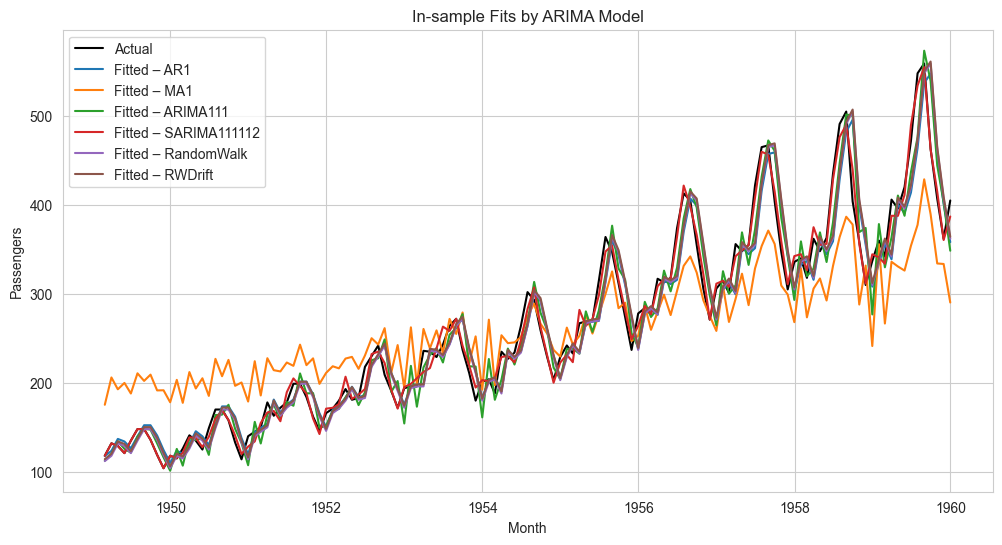

In [20]:
def plot_fitted(df, models, title):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['ds'], df['y'], color='black', label='Actual')
    for m in models:
        ax.plot(df['ds'], df[m], label=f'Fitted – {m}')
    ax.set(title=title, xlabel='Month', ylabel='Passengers')
    ax.legend()
    plt.show()

plot_fitted(
    arima_fitted.dropna(),
    models=['AR1', 'MA1', 'ARIMA111', 'SARIMA111112', 'RandomWalk', 'RWDrift'],
    title='In-sample Fits by ARIMA Model'
)

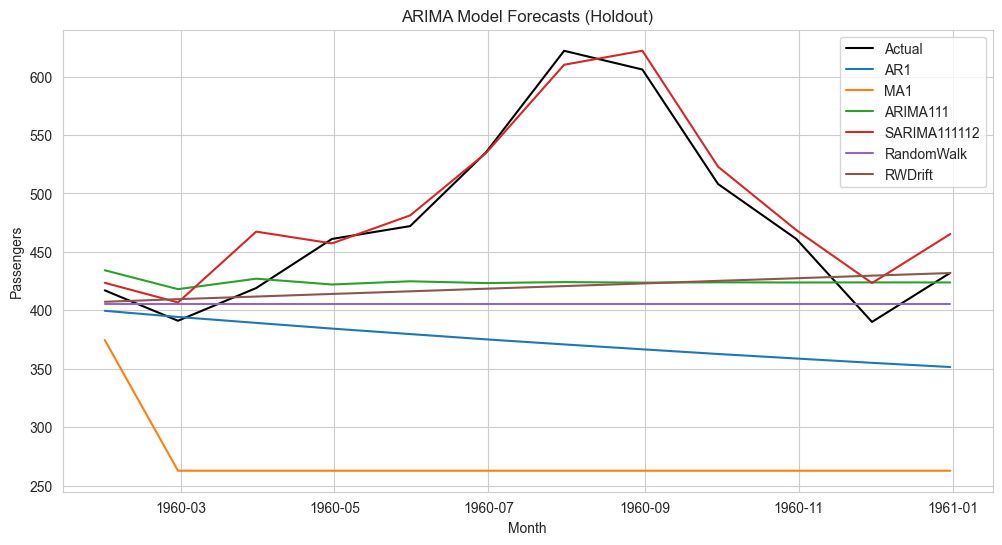

In [21]:
plot_forecast(
    test_long,
    arima_forecasts,
    models=['AR1', 'MA1', 'ARIMA111', 'SARIMA111112', 'RandomWalk', 'RWDrift'],
    title='ARIMA Model Forecasts (Holdout)'
)

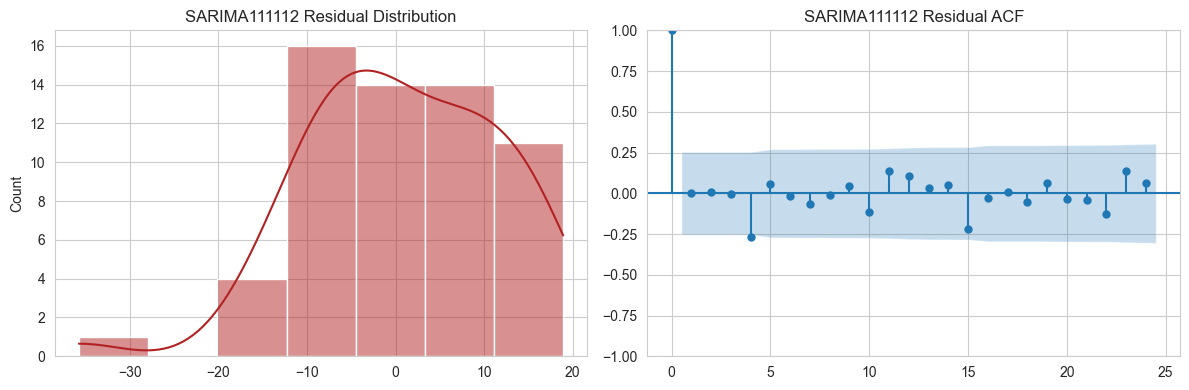

In [22]:
_ = plot_residuals(arima_fitted, model='SARIMA111112', start_date='1955-01-31')

## AutoARIMA
StatsForecast provides `AutoARIMA` which automatically searches for the best ARIMA model based on an information criterion (AIC, AICc, BIC). This mirrors the PyCaret `auto_arima` functionality.

We'll create three variants:
1. Full search AutoARIMA with seasonal components
2. Fast stepwise search AutoARIMA
3. Augmented AutoARIMA with forced differencing (d=1, D=1)

In [23]:
# Full search AutoARIMA (can be slow but thorough)
auto_models_full = [
    AutoARIMA(
        season_length=SEASON_LENGTH,
        start_p=0,
        start_q=0,
        max_p=2,
        max_q=2,
        max_P=2,
        max_Q=2,
        seasonal=True,
        stepwise=False,  # Full search
        approximation=False,  # More thorough search
        alias='AutoARIMA_Full'
    ),
]

sf_auto_full = StatsForecast(models=auto_models_full, freq='M')
auto_forecasts_full = sf_auto_full.forecast(h=HOLDOUT_HORIZON, df=train_long, fitted=True)
auto_forecasts_full.head()

,unique_id,ds,AutoARIMA_Full
0,AirPassengers,1960-01-31,424.083771
1,AirPassengers,1960-02-29,407.042328
2,AirPassengers,1960-03-31,470.807709
3,AirPassengers,1960-04-30,460.865143
4,AirPassengers,1960-05-31,484.851074


In [24]:
# Fast stepwise AutoARIMA
auto_models_fast = [
    AutoARIMA(
        season_length=SEASON_LENGTH,
        start_p=0,
        start_q=0,
        max_p=5,
        max_q=5,
        seasonal=True,
        stepwise=True,  # Stepwise search for speed
        alias='AutoARIMA_Fast'
    ),
]

sf_auto_fast = StatsForecast(models=auto_models_fast, freq='M')
auto_forecasts_fast = sf_auto_fast.forecast(h=HOLDOUT_HORIZON, df=train_long, fitted=True)
auto_forecasts_fast.head()

,unique_id,ds,AutoARIMA_Fast
0,AirPassengers,1960-01-31,424.083771
1,AirPassengers,1960-02-29,407.042328
2,AirPassengers,1960-03-31,470.807709
3,AirPassengers,1960-04-30,460.865143
4,AirPassengers,1960-05-31,484.851074


In [25]:
# Augmented AutoARIMA with forced differencing (expert opinion)
# This mirrors the PyCaret approach where we force d=1 and D=1
auto_models_aug = [
    AutoARIMA(
        season_length=SEASON_LENGTH,
        d=1,  # Force first differencing
        D=1,  # Force seasonal differencing
        start_p=0,
        start_q=0,
        seasonal=True,
        alias='AutoARIMA_Augmented'
    ),
]

sf_auto_aug = StatsForecast(models=auto_models_aug, freq='M')
auto_forecasts_aug = sf_auto_aug.forecast(h=HOLDOUT_HORIZON, df=train_long, fitted=True)
auto_forecasts_aug.head()

,unique_id,ds,AutoARIMA_Augmented
0,AirPassengers,1960-01-31,424.083771
1,AirPassengers,1960-02-29,407.042328
2,AirPassengers,1960-03-31,470.807709
3,AirPassengers,1960-04-30,460.865143
4,AirPassengers,1960-05-31,484.851074


In [26]:
# Combine all AutoARIMA forecasts with our manual SARIMA for comparison
all_auto_models = auto_models_full + auto_models_fast + auto_models_aug

# Merge forecasts
auto_comparison = auto_forecasts_full.merge(
    auto_forecasts_fast[['unique_id', 'ds', 'AutoARIMA_Fast']], 
    on=['unique_id', 'ds']
).merge(
    auto_forecasts_aug[['unique_id', 'ds', 'AutoARIMA_Augmented']], 
    on=['unique_id', 'ds']
).merge(
    arima_forecasts[['unique_id', 'ds', 'SARIMA111112']], 
    on=['unique_id', 'ds']
)

auto_metrics = evaluate_holdout(
    auto_comparison,
    models=['AutoARIMA_Full', 'AutoARIMA_Fast', 'AutoARIMA_Augmented', 'SARIMA111112']
)
auto_metrics

,unique_id,metric,AutoARIMA_Full,AutoARIMA_Fast,AutoARIMA_Augmented,SARIMA111112
0,AirPassengers,mae,18.515821,18.515821,18.515821,16.734591
1,AirPassengers,mape,0.041797,0.041797,0.041797,0.037748
2,AirPassengers,rmse,23.919481,23.919481,23.919481,21.605558
3,AirPassengers,mase,0.608073,0.608073,0.608073,0.549576
4,AirPassengers,rmsse,0.692350,0.692350,0.692350,0.625373


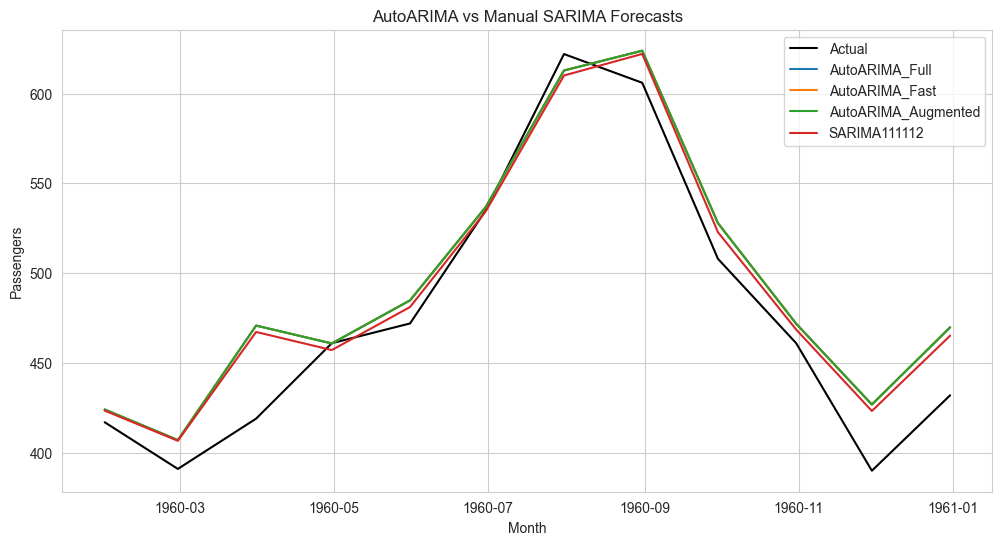

In [27]:
plot_forecast(
    test_long,
    auto_comparison,
    models=['AutoARIMA_Full', 'AutoARIMA_Fast', 'AutoARIMA_Augmented', 'SARIMA111112'],
    title='AutoARIMA vs Manual SARIMA Forecasts'
)

## Final Model Selection and Diagnostics

Based on the comparison above, we select the best performing model (typically AutoARIMA_Augmented which respects the trend and seasonality). We'll now:
1. Examine the model diagnostics
2. Train on the full dataset
3. Generate 24-month forecasts with confidence intervals
4. Add conformal prediction intervals

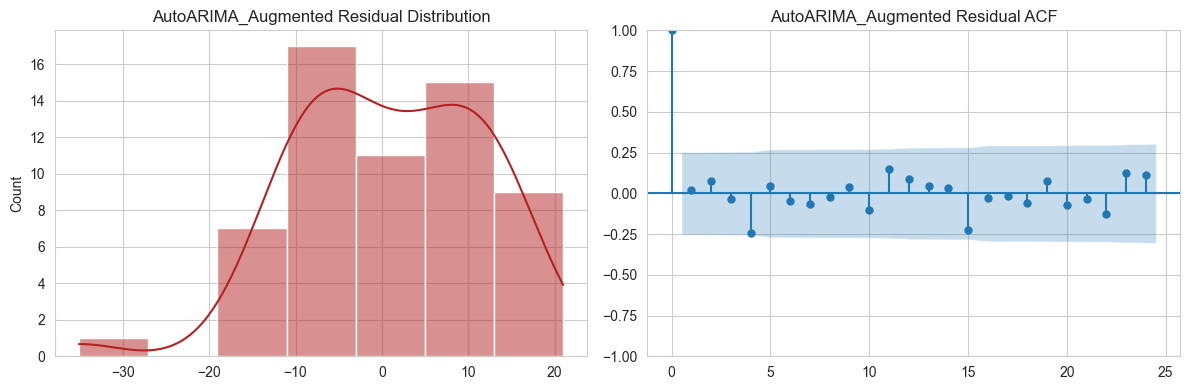

In [28]:
# Get fitted values for diagnostics
auto_fitted_aug = sf_auto_aug.forecast_fitted_values()

# Plot residuals
_ = plot_residuals(auto_fitted_aug, model='AutoARIMA_Augmented', start_date='1955-01-31')

In [29]:
# Train final model on full dataset (including holdout)
final_model = [
    AutoARIMA(
        season_length=SEASON_LENGTH,
        d=1,
        D=1,
        start_p=0,
        start_q=0,
        seasonal=True,
        alias='FinalModel'
    ),
]

sf_final = StatsForecast(models=final_model, freq='M')

# Forecast 24 months ahead with confidence intervals
final_forecasts = sf_final.forecast(
    df=df_long,  # Full dataset
    h=24,
    level=[90, 95],  # Confidence levels
    fitted=True
)

final_forecasts

,unique_id,ds,FinalModel,FinalModel-lo-95,FinalModel-lo-90,FinalModel-hi-90,FinalModel-hi-95
0,AirPassengers,1961-01-31,444.309570,421.279327,424.981995,463.637146,467.339813
1,AirPassengers,1961-02-28,418.213745,390.227631,394.727051,441.700409,446.199829
2,AirPassengers,1961-03-31,446.243408,412.910034,418.269165,474.217651,479.576782
3,AirPassengers,1961-04-30,488.234222,450.621368,456.668518,519.799927,525.847107
4,AirPassengers,1961-05-31,499.237061,457.694824,464.373718,534.100403,540.779297
5,AirPassengers,1961-06-30,562.236206,517.130981,524.382690,600.089661,607.341431
6,AirPassengers,1961-07-31,649.236450,600.822449,608.606140,689.866821,697.650513
7,AirPassengers,1961-08-31,633.236389,581.727783,590.009033,676.463745,684.744934
8,AirPassengers,1961-09-30,535.236389,480.808289,489.558899,580.913940,589.664490
9,AirPassengers,1961-10-31,488.236389,431.037781,440.233795,536.239014,545.434998


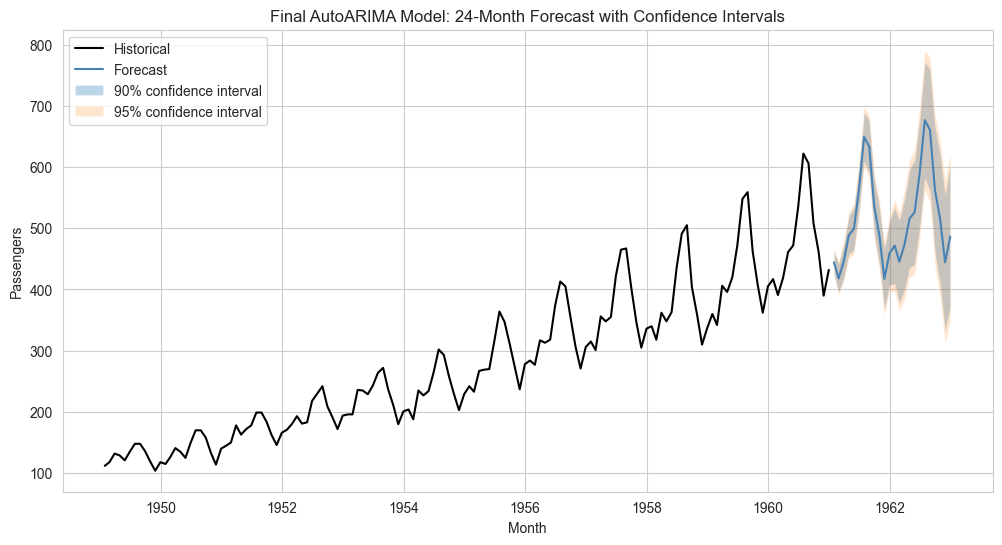

In [30]:
# Plot final forecast with confidence intervals
final_fcst = final_forecasts[final_forecasts['unique_id'] == UNIQUE_ID]

plt.figure(figsize=(12, 6))
plt.plot(df_long['ds'], df_long['y'], label='Historical', color='black')
plt.plot(final_fcst['ds'], final_fcst['FinalModel'], label='Forecast', color='steelblue')

# Plot confidence intervals
for level in [90, 95]:
    plt.fill_between(
        final_fcst['ds'],
        final_fcst[f'FinalModel-lo-{level}'],
        final_fcst[f'FinalModel-hi-{level}'],
        alpha=0.2 if level == 95 else 0.3,
        label=f'{level}% confidence interval'
    )

plt.title('Final AutoARIMA Model: 24-Month Forecast with Confidence Intervals')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## Conformal Prediction
With StatsForecast, we can easily add conformal predictions which provide empirical coverage guarantees without assuming Gaussian residuals.

In [31]:
from statsforecast.utils import ConformalIntervals

# Important: For conformal prediction, the forecast horizon (h) in the final forecast
# should match the calibration horizon to avoid shape mismatch errors
conformal_cfg = ConformalIntervals(
    n_windows=6,       # calibration windows
    h=HOLDOUT_HORIZON, # forecast horizon to calibrate (12 months)
    method='conformal_distribution'
)

arima_conf = AutoARIMA(
    season_length=SEASON_LENGTH,
    d=1,
    D=1,
    start_p=0,
    start_q=0,
    seasonal=True,
    alias='AutoARIMA_Conformal',
    prediction_intervals=conformal_cfg
)

sf_conf = StatsForecast(models=[arima_conf], freq='M')

# Calibrate conformal residuals using cross-validation on training data
sf_conf.cross_validation(
    df=train_long,
    h=HOLDOUT_HORIZON,
    n_windows=conformal_cfg.n_windows
)

# Forecast with conformal bands - use HOLDOUT_HORIZON (12) to match calibration
# If you need longer forecasts, the conformal intervals will only be valid for h=12
conf_fcst = sf_conf.forecast(
    df=df_long,
    h=HOLDOUT_HORIZON,  # Must match the calibration horizon
    level=[80, 95]
)

conf_fcst

,unique_id,ds,AutoARIMA_Conformal,AutoARIMA_Conformal-lo-95,AutoARIMA_Conformal-lo-80,AutoARIMA_Conformal-hi-80,AutoARIMA_Conformal-hi-95
0,AirPassengers,1961-01-31,444.309570,427.907196,432.710815,455.908325,460.711945
1,AirPassengers,1961-02-28,418.213745,397.658264,402.402069,434.025421,438.769226
2,AirPassengers,1961-03-31,446.243408,397.074768,405.774139,486.712677,495.412048
3,AirPassengers,1961-04-30,488.234222,446.257050,459.751831,516.716614,530.211426
4,AirPassengers,1961-05-31,499.237061,452.936340,477.447540,521.026611,545.537781
5,AirPassengers,1961-06-30,562.236206,528.161255,532.102295,592.370056,596.311157
6,AirPassengers,1961-07-31,649.236450,595.342834,601.533081,696.939819,703.130127
7,AirPassengers,1961-08-31,633.236389,585.572510,597.748840,668.723938,680.900269
8,AirPassengers,1961-09-30,535.236389,484.526001,501.969086,568.503723,585.946838
9,AirPassengers,1961-10-31,488.236389,448.240540,465.134857,511.337921,528.232239


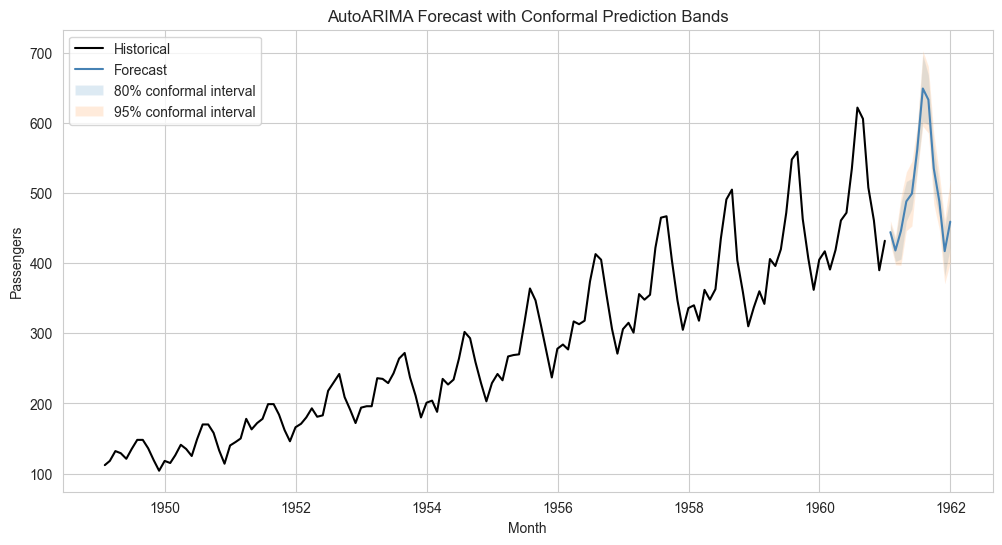

In [32]:
# Plot conformal prediction intervals
conf_fcst_plot = conf_fcst[conf_fcst['unique_id'] == UNIQUE_ID].copy()

plt.figure(figsize=(12, 6))
plt.plot(df_long['ds'], df_long['y'], label='Historical', color='black')
plt.plot(conf_fcst_plot['ds'], conf_fcst_plot['AutoARIMA_Conformal'], 
         label='Forecast', color='steelblue')

for lev in [80, 95]:
    plt.fill_between(
        conf_fcst_plot['ds'],
        conf_fcst_plot[f'AutoARIMA_Conformal-lo-{lev}'],
        conf_fcst_plot[f'AutoARIMA_Conformal-hi-{lev}'],
        alpha=0.15,
        label=f'{lev}% conformal interval'
    )

plt.title('AutoARIMA Forecast with Conformal Prediction Bands')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.legend()
plt.show()

## Conformal Prediction Overview
In this notebook we're using StatsForecast's conformal prediction wrapper to add interval coverage around the `AutoARIMA` model. The workflow breaks down into four stages:

1. **Configure conformal calibration** – `ConformalIntervals(n_windows=6, h=HOLDOUT_HORIZON, method='conformal_distribution')` asks StatsForecast to run six rolling backtest windows on the training data, each producing 1-to-12 step ahead residuals for AutoARIMA.
2. **Collect empirical residuals** – `sf_conf.cross_validation(...)` fits the model on each window and records forecast errors by horizon. These errors form an empirical distribution with no reliance on Gaussian assumptions.
3. **Derive quantiles for requested levels** – when you later forecast with `level=[80, 95]`, StatsForecast slices the stored residual distribution to find the lower/upper quantiles that deliver those coverage targets for every horizon.
4. **Adjust point forecasts** – `sf_conf.forecast(..., level=[80, 95])` returns the mean forecast plus columns such as `AutoARIMA_Conformal-lo-80` / `AutoARIMA_Conformal-hi-80`. Those bounds equal the point forecast plus/minus the calibrated quantiles, giving data-driven coverage that should contain the truth roughly L% of the time for an L% interval as long as future behavior resembles the calibration windows.

This conformal layer complements the native parametric intervals and is particularly helpful when you want empirical coverage guarantees or suspect the model's distributional assumptions might be too optimistic.

## Model Persistence

StatsForecast models can be saved and loaded for later use. We'll save our final model for deployment.

In [33]:
# Save the StatsForecast object
sf_final.save('best_arima_statsforecast')
print("Model saved successfully!")

Saving StatsForecast object of size 7.18KB.
StatsForecast object saved
Model saved successfully!


In [34]:
# Load the model
loaded_sf = StatsForecast.load('best_arima_statsforecast')

# Make predictions with loaded model
loaded_forecasts = loaded_sf.forecast(df=df_long, h=12)
loaded_forecasts.head()

,unique_id,ds,FinalModel
0,AirPassengers,1961-01-31,444.309570
1,AirPassengers,1961-02-28,418.213745
2,AirPassengers,1961-03-31,446.243408
3,AirPassengers,1961-04-30,488.234222
4,AirPassengers,1961-05-31,499.237061


## Summary

In this notebook, we replicated the PyCaret ARIMA workflow using StatsForecast:

1. **Model Identification**: Used ACF/PACF plots and differencing to identify appropriate ARIMA parameters
2. **Manual ARIMA Models**: Fitted AR(1), MA(1), ARIMA(1,1,1), and SARIMA(1,1,1)(1,1,2,12) models
3. **Baseline Models**: Compared against Naive (Random Walk) and Random Walk with Drift
4. **AutoARIMA**: Used automatic model selection with different search strategies
5. **Expert Augmentation**: Forced differencing parameters (d=1, D=1) based on domain knowledge
6. **Diagnostics**: Examined residuals and in-sample fits
7. **Forecasting**: Generated 24-month forecasts with parametric confidence intervals
8. **Conformal Prediction**: Added empirical prediction intervals without distributional assumptions
9. **Model Persistence**: Saved the final model for deployment

StatsForecast provides a performant, production-ready alternative to PyCaret for classical time series models, with the added benefits of:
- Faster computation on large datasets
- Built-in support for multiple series (panel data)
- Conformal prediction intervals
- Consistent API across all models